In [ ]:
# Load Data
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install transformers torch
from transformers import BertTokenizer, BertModel,BertForSequenceClassification

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
import numpy as np
import torch

## 1. Define DataSet and Dataloaders for Claims Text

In [ ]:
class BertDataset(Dataset):
    def __init__(self, csv_file,label_map, tokenizer, max_length=512):
        self.data_frame = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = label_map
        # redefine self.data_frame for integer valued labels
        self.data_frame['status'] = self.data_frame['status'].map(self.label_map)

    def __len__(self):
        return self.data_frame.shape[0]

    def __getitem__(self, idx):
        #text = self.data_frame.iloc[idx]['claims']
        text = self.data_frame.iloc[idx]['abstracts']

        label = self.data_frame.iloc[idx]['status']

        # Encoding the text using the BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
input_path = '/content/drive/MyDrive/CSCI567/project/data/text_df.csv'

# Load the dataset
label_map = {'ABN': 0, 'ISS': 1}
dataset = BertDataset(input_path,label_map=label_map, tokenizer=BertTokenizer.from_pretrained('bert-base-cased'))
#dataset = BertDataset(input_path,label_map=label_map, tokenizer=BertTokenizer.from_pretrained('bert-large-cased'))

# Example dataset size
total_size = len(dataset)

# Define the proportions
train_size = int(0.95* total_size)
val_size = int(0.025* total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# define dataloaders
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

9440
248
249


## 2. Fine Tune Pretrained BERT

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

# Number of epochs
num_epochs = 20

# load model for BERT classification
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
#model = BertForSequenceClassification.from_pretrained('bert-large-cased', num_labels=2)


# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Scheduler
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print loss or any other metrics you want to track
        #print(f"Loss: {loss.item()}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3. Evaluate BERT Performance on validation set

In [ ]:
# set model to evaluation mode
model.eval()

# store predictions in list
val_predictions = []
val_labels = []

# Evaluate on validation set
with torch.no_grad():
    for batch in val_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=1)
        labels = batch['labels']

        # Store predictions
        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [ ]:
# Use SKLearn library to predict F1, Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

f1 = f1_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
accuracy = accuracy_score(val_labels, val_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.6935483870967742
F1 Score: 0.7790697674418605
Precision: 0.7657142857142857
Recall: 0.7928994082840237


175
73


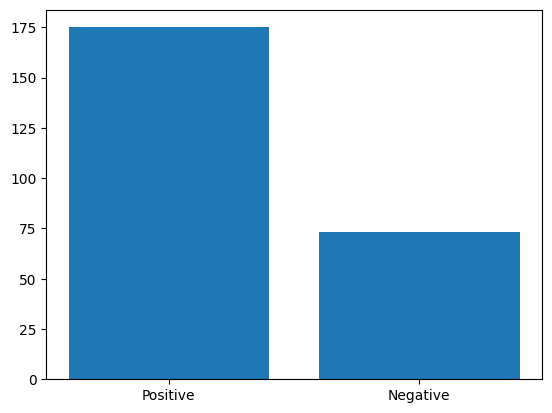

In [ ]:
# Plot the proportion of positive vs. negative predictions
import matplotlib.pyplot as plt

print(val_predictions.count(1))
print(val_predictions.count(0))

plt.bar(['Positive', 'Negative'], [val_predictions.count(1), val_predictions.count(0)])
plt.show()

## (Optional): Save Model

In [ ]:
# model_save_path = '/content/drive/MyDrive/CSCI567/project/saved_models/bert_state_dict.pth'
# torch.save(model.state_dict(), model_save_path)

# # Look into higher GPU